In [150]:
import os
import glob
import pickle

from astropy.io import fits
import numpy as np
from matplotlib import pyplot
%matplotlib inline

In [2]:
obsid_base = '000340400'
os.chdir('../data/swiftuvot/reduced')
original_dir = os.getcwd()

In [3]:
good_range = [1700,2740]
contamination_range = [2740, 5000]
pa_dict = {1:248, 5:248, 9:248}
visit_list = [1, 5, 9]

In [400]:
def norm_background(obsid, ext):
    '''
    Background in pha file is the sum over the whole slit and therefore shows jumps when a new pixel is
    included in the slit width. This normalizes out the slit width, returning the background
    in counts/s/pix
    
    This is not incredibly robust at matching the two spectra - should be visually inspected
    '''
    ofile = open('getspec_output_{}_{}.pkl'.format(obsid, ext), 'rb')
    output_dict = pickle.load(ofile, encoding='latin1')
    Y2 = output_dict['Y2']
    borderup, borderdown=Y2[3]
    fit = Y2[0]
    (q0,q1,q2,q3)= fit[1] 

    slitwidth = borderup[1, q1[0]]-borderdown[1, q1[0]] #look at relevant data and the 1st order slit
    slitwidth = slitwidth[slitwidth>0] #look at non-zero slit widths
    tbdata = fits.getdata('sw{}ugu_1ord_{}_f.pha'.format(obsid, ext), 2)

    indx = np.argsort(tbdata['bkgrate1'][1:] - tbdata['bkgrate1'][:-1])
    pix = np.arange(len(tbdata))
    pix2 = np.arange(len(slitwidth))
    indx2 = np.argsort(slitwidth[1:] - slitwidth[:-1])
    num_change = len(set(slitwidth))
    pix4 = np.sort(pix2[indx2[-num_change:]])
    pix3 = np.sort(pix[indx[-num_change:]])
    if pix4[0] in pix3:
        offset = 0
    else:
        offset = pix4[0] - pix3[0]
    print('Found offset of {}'.format(offset))
    aligned_slitwidth = np.interp(pix, pix2 - offset, slitwidth)
    return(tbdata['bkgrate1']/aligned_slitwidth)

# Plot Backgrounds to make sure they are the same

Found offset of 12
Found offset of 10
Found offset of 13
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 12
Found offset of 10
Found offset of 13
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 0


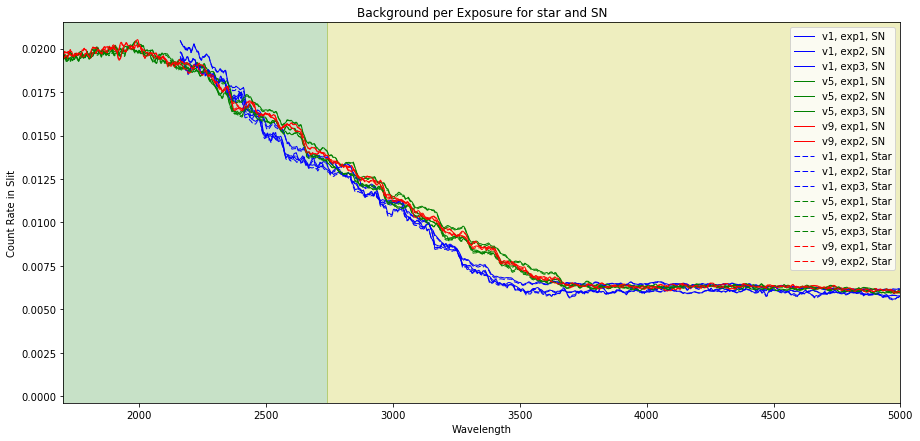

In [401]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,7])
ax1 = fig.add_subplot(1,1,1)
ax1.axvspan(good_range[0], good_range[1],color='ForestGreen', alpha = 0.25)
ax1.axvspan(contamination_range[0], contamination_range[1], color='y', alpha=0.25)

waveoffset = [500, 0, 0]

for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid, 'uvot', 'image'))
    flist = glob.glob('*pha*')
    for exp, ifile in enumerate(flist):
        tbdata = fits.getdata(ifile, 2)
        bkg_rate = norm_background(obsid, exp+1)
        ax1.plot(tbdata['lambda']+waveoffset[i], bkg_rate, color=colors[i],
                label='v{}, exp{}, {}'.format(obs,exp+1,'SN'))
        
    os.chdir(original_dir)
for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid+"_star", 'uvot', 'image'))
    flist = glob.glob('*pha*')
    for exp, ifile in enumerate(flist):
        tbdata = fits.getdata(ifile, 2)
        bkg_rate = norm_background(obsid, exp+1)
        ax1.plot(tbdata['lambda']+waveoffset[i], bkg_rate, color=colors[i],ls='--',
                label='v{}, exp{}, {}'.format(obs,exp+1,'Star'))
        
    os.chdir(original_dir)

ax1.set_xlim(good_range[0], contamination_range[1])
ax1.set_title('Background per Exposure for star and SN')
ax1.set_ylabel("Count Rate in Slit")
ax1.set_xlabel("Wavelength")
ax1.legend(loc='best')

pyplot.savefig('../../../figures/background_rate_compstar.pdf')

### Why is the background in visit 1 so different from visits 5 and 9?

Shifting the visit 1 background helps align them. Is this something that's corrected for in the pipeline - maybe look at the anchor points? (see below)

Visit 1 seems to have a slightly different slope (see below)

This plot was to confirm that the backgrounds from the star and the SN are not significantly different

# Plot Spectra for all exposures

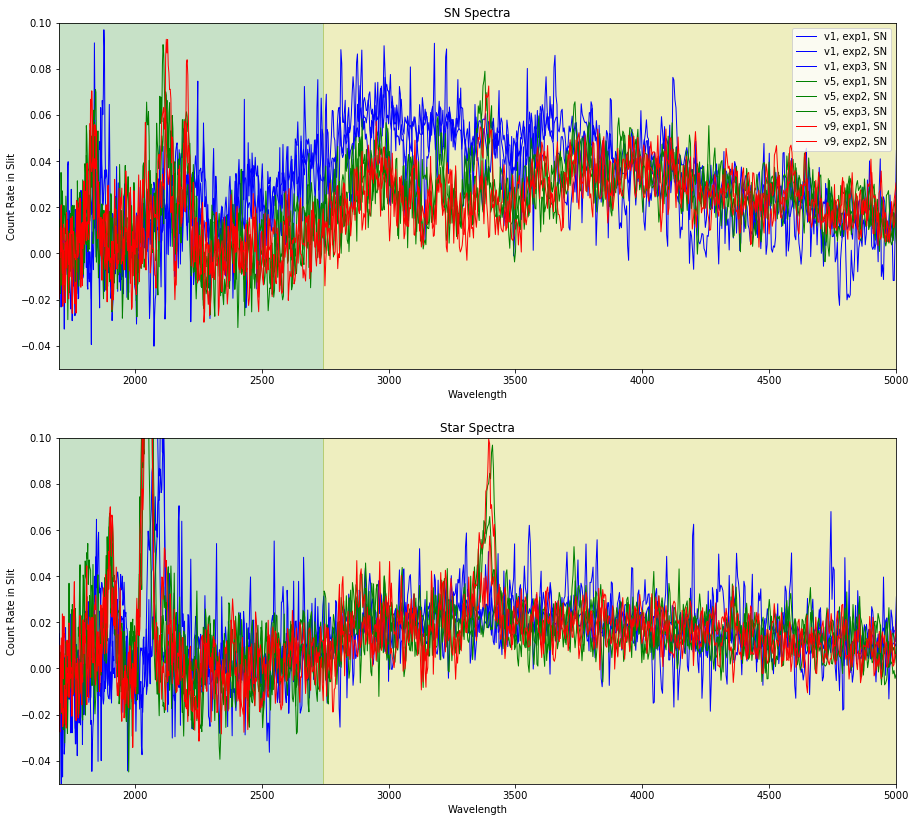

In [15]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15, 14])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.axvspan(good_range[0], good_range[1],color='ForestGreen', alpha = 0.25)
ax1.axvspan(contamination_range[0], contamination_range[1], color='y', alpha=0.25)
ax2.axvspan(good_range[0], good_range[1],color='ForestGreen', alpha = 0.25)
ax2.axvspan(contamination_range[0], contamination_range[1], color='y', alpha=0.25)

for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid, 'uvot', 'image'))
    flist = glob.glob('*pha*')
    for exp, ifile in enumerate(flist):
        tbdata = fits.getdata(ifile, 2)
        ax1.plot(tbdata['lambda'], tbdata['netrate'], color=colors[i],
                label='v{}, exp{}, {}'.format(obs,exp+1,'SN'))
        
    os.chdir(original_dir)
for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid+"_star", 'uvot', 'image'))
    flist = glob.glob('*pha*')
    for exp, ifile in enumerate(flist):
        tbdata = fits.getdata(ifile, 2)
        ax2.plot(tbdata['lambda'], tbdata['netrate'], color=colors[i],
                label='v{}, exp{}, {}'.format(obs,exp+1,'Star'))
        
    os.chdir(original_dir)

ax1.set_xlim(good_range[0], contamination_range[1])
ax1.set_ylim(-0.05, 0.1)
ax1.set_title('SN Spectra')
ax1.set_ylabel("Count Rate in Slit")
ax1.set_xlabel("Wavelength")
ax1.legend(loc='best')

ax2.set_xlim(good_range[0], contamination_range[1])
ax2.set_ylim(-0.05, 0.1)
ax2.set_title('Star Spectra')
ax2.set_ylabel("Count Rate in Slit")
ax2.set_xlabel("Wavelength")

pyplot.savefig('../../../figures/flux_compstar.pdf')

A slight offset in wavelength space fixed below

# Plot the Summed Spectra to see things more clearly

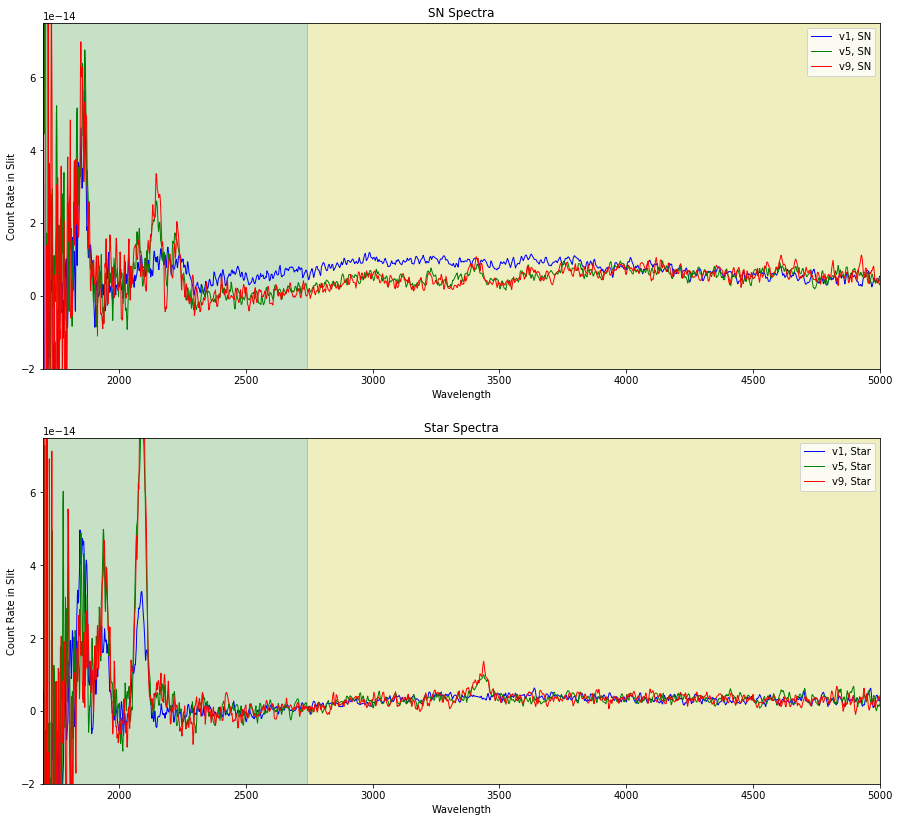

In [403]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15, 14])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.axvspan(good_range[0], good_range[1],color='ForestGreen', alpha = 0.25)
ax1.axvspan(contamination_range[0], contamination_range[1], color='y', alpha=0.25)
ax2.axvspan(good_range[0], good_range[1],color='ForestGreen', alpha = 0.25)
ax2.axvspan(contamination_range[0], contamination_range[1], color='y', alpha=0.25)

for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid, 'uvot', 'image'))
    x1d = fits.getdata('{}_x1dsum.fits'.format(obsid), 1)
    if obs != 1:
        wave_offset=25
    else:
        wave_offset=0
    ax1.plot(x1d['wave']+wave_offset, x1d['flux'], color=colors[i],
                label='v{}, {}'.format(obs,'SN'))

    os.chdir(original_dir)
for i, obs in enumerate(visit_list):
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid+"_star", 'uvot', 'image'))
    if obs != 1:
        wave_offset=40
    else:
        wave_offset=0
    x1d = fits.getdata('{}_x1dsum.fits'.format(obsid), 1)
    ax2.plot(x1d['wave']+wave_offset, x1d['flux'], color=colors[i],
                label='v{}, {}'.format(obs,'Star'))
        
    os.chdir(original_dir)

ax1.set_xlim(good_range[0], contamination_range[1])
ax1.set_ylim(-2E-14, 0.75E-13)
ax1.set_title('SN Spectra')
ax1.set_ylabel("Count Rate in Slit")
ax1.set_xlabel("Wavelength")
ax1.legend(loc='best')

ax2.set_xlim(good_range[0], contamination_range[1])
ax2.set_ylim(-2E-14, 0.75E-13)
ax2.set_title('Star Spectra')
ax2.set_ylabel("Count Rate in Slit")
ax2.set_xlabel("Wavelength")
ax2.legend(loc='best')

pyplot.savefig('../../../figures/flux_compstar_summed.pdf')

A slight offset in wavelength space manually corrected. Still not sure why visit 1 shows different emission than visits 5 and 9. I'd like to resolve this

# Look at top and bottom background from each Visit

This is to check that there is no significant difference between the background (e.g. if there was zeroth order contamination in one, I think I'd see it here)

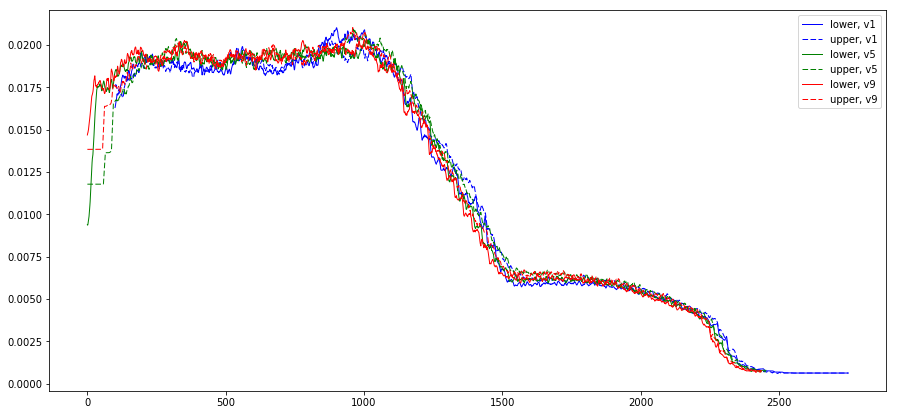

In [114]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,7])
ax1 = fig.add_subplot(1,1,1)

exptime = [1906.22, 946.59, 892.48]
pix_offset = [100, 0, 0]
pix = np.arange(0, 2800)

for i, obs in enumerate(visit_list):
    
    obsid = '{}{:2}'.format(obsid_base, obs).replace(' ', '0')
    os.chdir(os.path.join(obsid, 'uvot', 'image'))
    bkg_tbdata = fits.getdata('bkg_{}_2.fits'.format(obsid), 1)
    ax1.plot(pix[0:len(bkg_tbdata['bkg_lower'])]+pix_offset[i], bkg_tbdata['bkg_lower']/exptime[i], label='lower, v{}'.format(obs), color=colors[i])
    ax1.plot(pix[0:len(bkg_tbdata['bkg_upper'])]+pix_offset[i],bkg_tbdata['bkg_upper']/exptime[i], label='upper, v{}'.format(obs), color=colors[i], ls='--')
    
    os.chdir(original_dir)
    
ax1.legend(loc='best')

Looking at upper and lower background values used to find the background. With a manual shift in pixel space these line up pretty well. This tells me that there aren't any sources contaminating the background in a big way (b/c upper and lower match well) and that there isn't a big difference in the background between the different visits with the exception of the pixel scale (maybe the anchor point)

# Compare to background in PHA table

This is to check that what is reported as upper and lower matches what is put in the PHA tables. This is also where I start to explort the croping of the PHA table compared to the upper and lower values

Found offset of 10
Found offset of 0
Found offset of 0


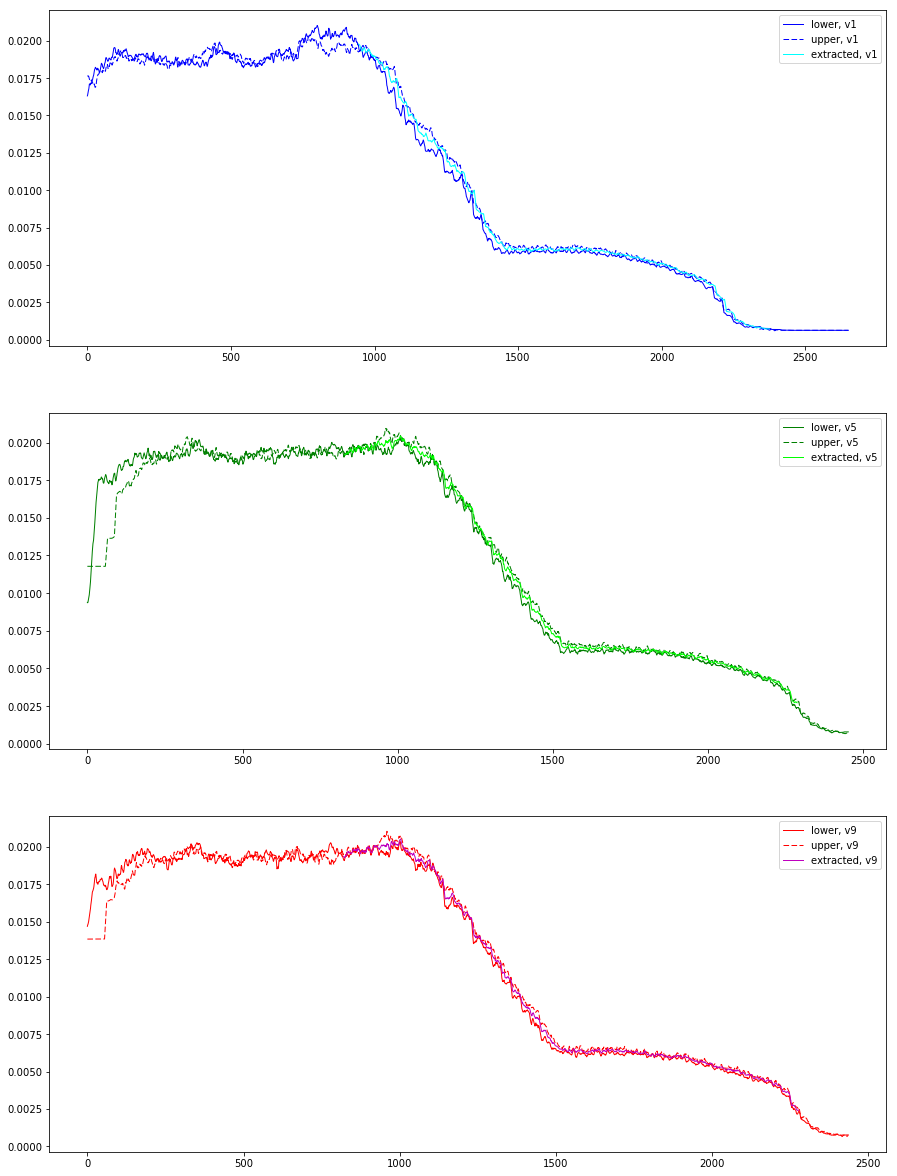

In [382]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,21])
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

exptime = [1906.22, 946.59, 892.48]
pix_offset = [945, 830, 820]
pix = np.arange(0, 2800)

obsid = obsid_base+'01'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
bkg_tbdata = fits.getdata('bkg_{}_2.fits'.format(obsid), 1)
ax1.plot(pix[0:len(bkg_tbdata['bkg_lower'])], bkg_tbdata['bkg_lower']/exptime[0], label='lower, v1', color='b')
ax1.plot(pix[0:len(bkg_tbdata['bkg_upper'])],bkg_tbdata['bkg_upper']/exptime[0], label='upper, v1', color='b', ls='--')
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[0]), bkg_rate, color='cyan', label='extracted, v1')
os.chdir(original_dir)

obsid = obsid_base+'05'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
bkg_tbdata = fits.getdata('bkg_{}_2.fits'.format(obsid), 1)
ax2.plot(pix[0:len(bkg_tbdata['bkg_lower'])], bkg_tbdata['bkg_lower']/exptime[1], label='lower, v5', color='g')
ax2.plot(pix[0:len(bkg_tbdata['bkg_upper'])],bkg_tbdata['bkg_upper']/exptime[1], label='upper, v5', color='g', ls='--')
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax2.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[1]), bkg_rate, color='lime', label='extracted, v5')
os.chdir(original_dir)
    
obsid = obsid_base+'09'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
bkg_tbdata = fits.getdata('bkg_{}_2.fits'.format(obsid), 1)
ax3.plot(pix[0:len(bkg_tbdata['bkg_lower'])], bkg_tbdata['bkg_lower']/exptime[2], label='lower, v9', color='r')
ax3.plot(pix[0:len(bkg_tbdata['bkg_upper'])],bkg_tbdata['bkg_upper']/exptime[2], label='upper, v9', color='r', ls='--')
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax3.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[2]), bkg_rate, color='m', label = 'extracted, v9')
os.chdir(original_dir)    
    
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')


# Compare the PHA Background for one extension

I want to see if I shift visit 1 appropriately do these all have the same shape?

Found offset of 10
Found offset of 0
Found offset of 0


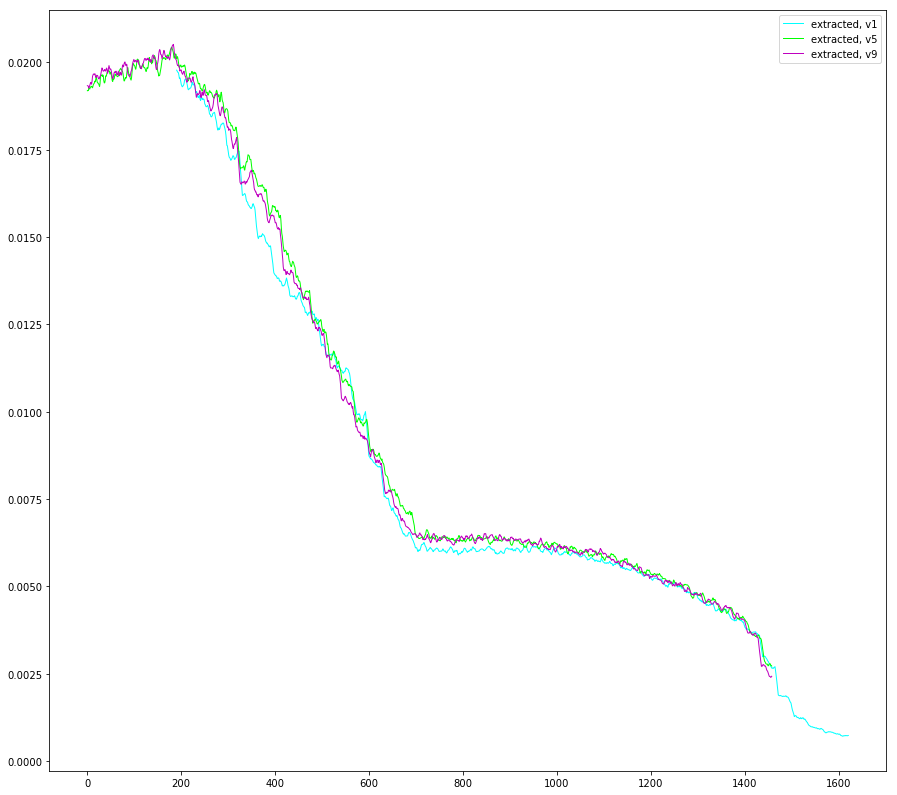

In [386]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,14])
ax1 = fig.add_subplot(1,1,1)


exptime = [1906.22, 946.59, 892.48]
pix_offset = [90, 0, 0]
pix = np.arange(0, 2800)

obsid = obsid_base+'01'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[0])+100, bkg_rate, color='cyan', label='extracted, v1')
os.chdir(original_dir)

obsid = obsid_base+'05'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[1]), bkg_rate, color='lime', label='extracted, v5')
os.chdir(original_dir)
    
obsid = obsid_base+'09'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[2]), bkg_rate, color='m', label = 'extracted, v9')
os.chdir(original_dir)    

ax1.legend(loc='best')

Combining the last plot and trying to adjust the pixel scale so things match up.

All in all these backgrounds are pretty similar. The first visit is a little different, slightly different slope and normalization.

# Investigate offset in wavelength space

Found offset of 10
Found offset of 0
Found offset of 0


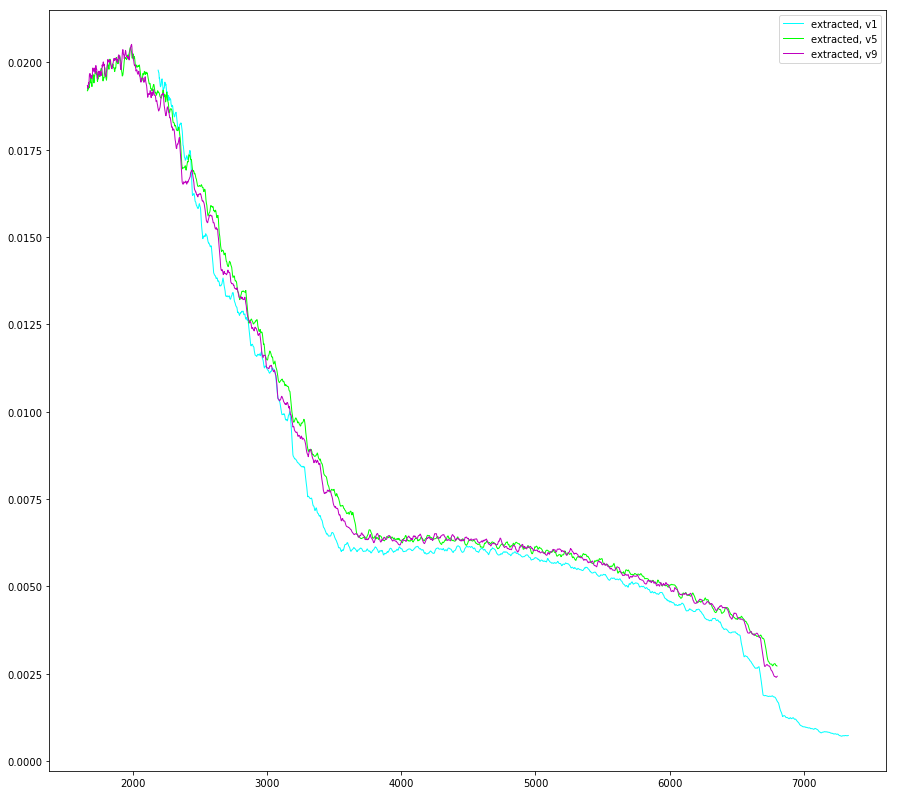

In [394]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,14])
ax1 = fig.add_subplot(1,1,1)


exptime = [1906.22, 946.59, 892.48]
wave_offset = [530, 0, 0]
pix = np.arange(0, 2800)

obsid = obsid_base+'01'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot(tbdata['lambda']+wave_offset[0], bkg_rate, color='cyan', label='extracted, v1')
os.chdir(original_dir)

obsid = obsid_base+'05'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot(tbdata['lambda'], bkg_rate, color='lime', label='extracted, v5')
os.chdir(original_dir)
    
obsid = obsid_base+'09'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot(tbdata['lambda'], bkg_rate, color='m', label = 'extracted, v9')
os.chdir(original_dir)    

ax1.legend(loc='best')

TODO: Use a real dispersion solution rather than an offset; things look much better in pixel space than wavelength space

In [344]:
os.chdir(original_dir)

# Does changing the background regions change the background?

I don't expect this to make a difference, but just in case ...

Found offset of 10
Found offset of 10
Found offset of 0
Found offset of 0
Found offset of 0
Found offset of 0


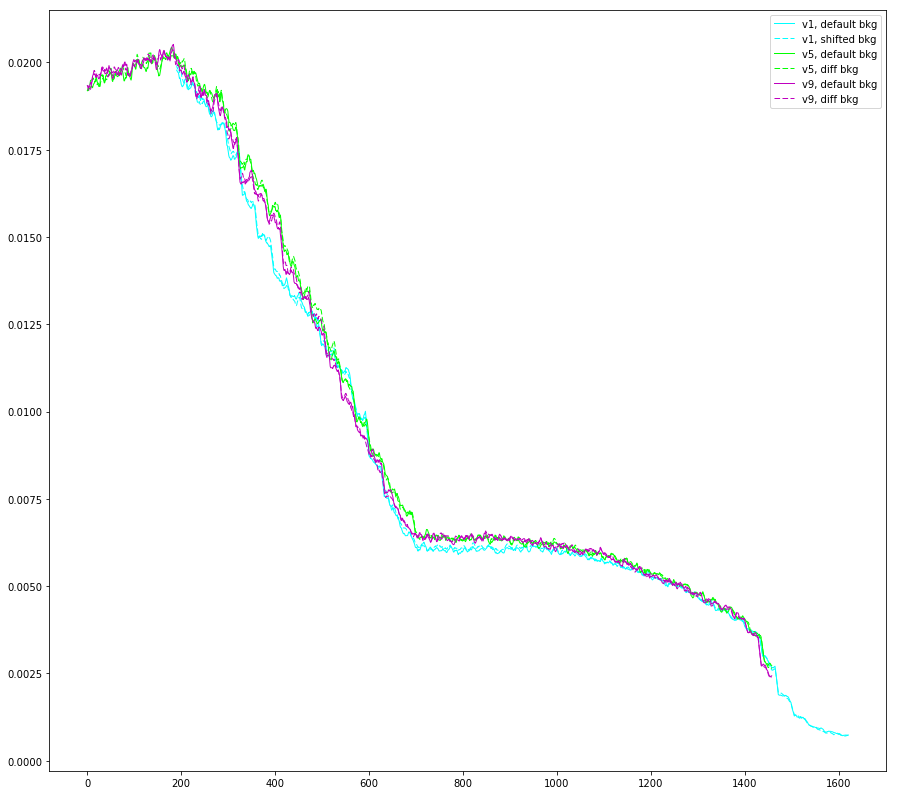

In [385]:
os.chdir(original_dir)
colors = ['b', 'g', 'r']
fig = pyplot.figure(figsize=[15,14])
ax1 = fig.add_subplot(1,1,1)


exptime = [1906.22, 946.59, 892.48]
pix_offset = [90, 0, 0]
pix = np.arange(0, 2800)

obsid = obsid_base+'01'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[0])+100, bkg_rate, color='cyan', label='v1, default bkg')
os.chdir(original_dir)

os.chdir(os.path.join(obsid+'_diffbkg', 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[0])+100, bkg_rate, color='cyan', label='v1, shifted bkg', ls='--')

os.chdir(original_dir)

obsid = obsid_base+'05'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[1]), bkg_rate, color='lime', label='v5, default bkg')
os.chdir(original_dir)

os.chdir(os.path.join(obsid+'_diffbkg', 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[1]), bkg_rate, color='lime', label='v5, diff bkg', ls='--')
os.chdir(original_dir)
    
obsid = obsid_base+'09'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[2]), bkg_rate, color='m', label = 'v9, default bkg')
os.chdir(original_dir)    

os.chdir(os.path.join(obsid+'_diffbkg', 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot((pix[0:len(tbdata['bkgrate1'])]+pix_offset[2]), bkg_rate, color='m', label = 'v9, diff bkg', ls='--')
os.chdir(original_dir)    

ax1.legend(loc='best')

As I suspected - changing the background didn't make a difference

# Investigate features in SN spectrum 

Found offset of 10
Found offset of 0
Found offset of 0


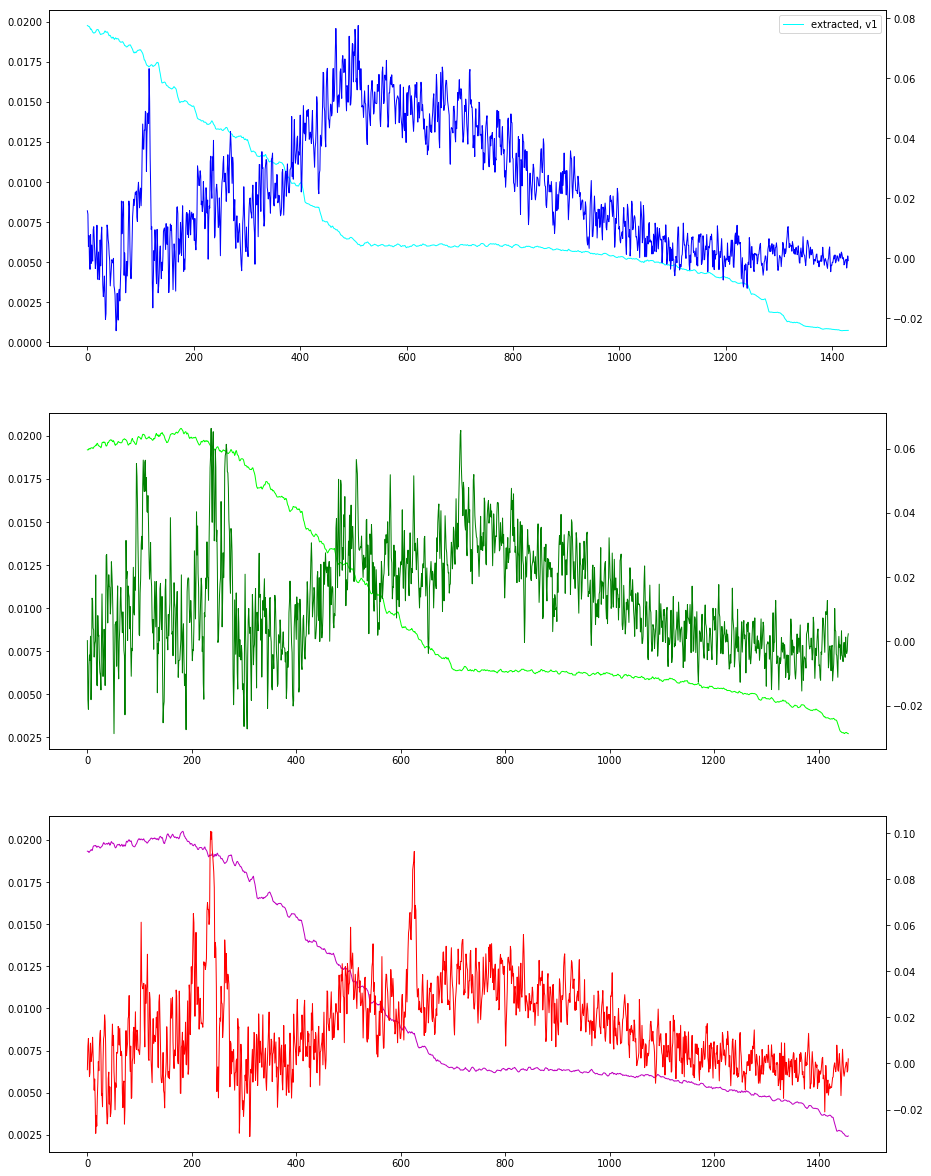

In [397]:
os.chdir(original_dir)
fig = pyplot.figure(figsize=[15,21])
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

exptime = [1906.22, 946.59, 892.48]
pix_offset = [90, 0, 0]
pix = np.arange(0, 2800)

obsid = obsid_base+'01'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax1.plot( bkg_rate, color='cyan', label='extracted, v1')
ax4 = ax1.twinx()
ax4.plot(tbdata['netrate'], color='b', label='extracted, v1')
os.chdir(original_dir)

obsid = obsid_base+'05'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax2.plot( bkg_rate, color='lime', label='extracted, v5')
ax5 = ax2.twinx()
ax5.plot(tbdata['netrate'], color='g', label='extracted, v5')
os.chdir(original_dir)
    
obsid = obsid_base+'09'
os.chdir(os.path.join(obsid, 'uvot', 'image'))
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)
bkg_rate = norm_background(obsid, 2)
ax3.plot(bkg_rate, color='m', label = 'extracted, v9')
ax6 = ax3.twinx()
ax6.plot(tbdata['netrate'], color='r', label='extracted, v9')
os.chdir(original_dir)    

ax1.legend(loc='best')

# Test Background Normalization

[  27   32  465  902 1344] [  32  465  902 1344 1549]


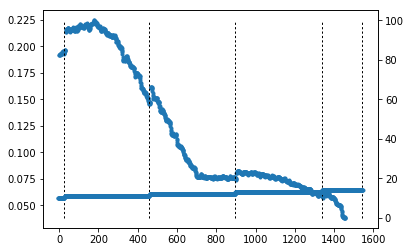

In [374]:
os.chdir(original_dir)
visit='05'
obsid = obsid_base+visit
os.chdir(os.path.join(obsid, 'uvot', 'image'))
ofile = open('getspec_output_000340400{}_2.pkl'.format(visit), 'rb')
output_dict = pickle.load(ofile, encoding='latin1')
Y2 = output_dict['Y2']
borderup, borderdown=Y2[3]
fit = Y2[0]
(q0,q1,q2,q3)= fit[1] 

slitwidth = borderup[1, q1[0]]-borderdown[1, q1[0]]
slitwidth = slitwidth[slitwidth>0]
tbdata = fits.getdata('sw{}ugu_1ord_2_f.pha'.format(obsid), 2)

indx = np.argsort(tbdata['bkgrate1'][1:] - tbdata['bkgrate1'][:-1])
pix = np.arange(len(tbdata))
ax1 = pyplot.subplot(111)
ax1.plot(pix, tbdata['bkgrate1'], 'o')

ax2 = ax1.twinx()
pix2 = np.arange(len(slitwidth))

indx2 = np.argsort(slitwidth[1:] - slitwidth[:-1])

num_change = len(set(slitwidth))

pix4 = np.sort(pix2[indx2[-num_change:]])
pix3 = np.sort(pix[indx[-num_change:]])
offset = pix4[0] - pix3[0]

ax2.plot(pix2-offset, slitwidth, 'o')
ax2.vlines(pix4-offset, 0, 100,linestyle=':')
print(pix3, pix4)

0 [  32  151  465  902 1344] [  32  465  902 1344 1549]


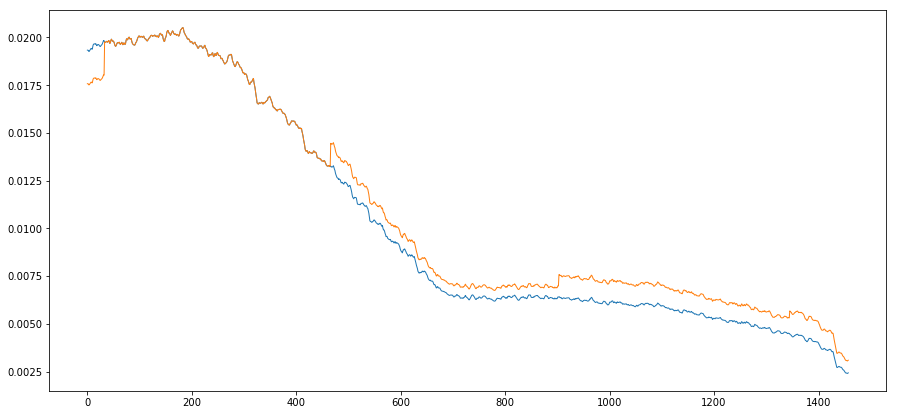

In [379]:
os.chdir(original_dir)
pyplot.figure(figsize=[15, 7])
visit='09'
ext=2
obsid = obsid_base+visit
os.chdir(os.path.join(obsid, 'uvot', 'image'))
norm_bkg = norm_background(obsid, ext)
pyplot.plot(norm_bkg)
tbdata = fits.getdata('sw{}ugu_1ord_{}_f.pha'.format(obsid, ext), 2)
pyplot.plot(tbdata['bkgrate1']/11)